## Imports

In [ ]:
import openai
import numpy as np
import inspect_ai
from tqdm.notebook import tqdm
import pandas as pd
from bert_score import score
from typing import Any
from matplotlib import pyplot as plt
import einops

In [ ]:
from inspect_ai import Task, task
from inspect_ai.dataset import Sample, csv_dataset
from inspect_ai.model import GenerateConfig
from inspect_ai.scorer import choice
from inspect_ai.solver import multiple_choice

## Summarize Questions

In [ ]:
def summarize_questions(questions, dev_prompt, user_prompt):
    '''
    questions: list / np array of the questions in gpqa diamond
    '''
    summarized = []

    for question in tqdm(questions):
        input_text = (f"{user_prompt}\n<question>{question}</question>")
        
        completion = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "developer", "content": f"{dev_prompt}"},
                {"role": "user", "content": input_text}
            ],
            temperature=0.5,
        )

        model_output = completion.choices[0].message.content
        summarized.append(model_output)
    
    return summarized

In [ ]:
dataset = pd.read_csv('gpqa/gpqa_diamond.csv')
questions = dataset['Question'].to_list()

In [ ]:
dev_prompt = 'Your task is to summarize the input question aggressively, while not losing any crucial information.'
user_prompt = ''

In [ ]:
summarized = summarize_questions(questions, dev_prompt, user_prompt)

In [ ]:
dataset['Summarized Question'] = summarized
dataset.to_csv('gpqa/updated_gpqa_diamond.csv')

## Running Evals

In [ ]:
dataset = pd.read_csv('gpqa/gpqa_diamond.csv')
questions = dataset['Question'].to_list()

In [ ]:
@task
def gpqa_diamond(cot: bool = True) -> Task:
    return Task(
        dataset=csv_dataset(
            csv_file="gpqa/updated_gpqa_diamond.csv",
            sample_fields=record_to_sample,
        ),
        solver=[
            multiple_choice(shuffle=True, cot=cot),
        ],
        scorer=choice(),
        config=GenerateConfig(temperature=0.5),
        epochs=1,
    )

def record_to_sample(record: dict[str, Any]) -> Sample:
    return Sample(
        input=record["Question"],
        choices=[
            str(record["Correct Answer"]),
            str(record["Incorrect Answer 1"]),
            str(record["Incorrect Answer 2"]),
            str(record["Incorrect Answer 3"]),
        ],
        target="A",
        id=record["Record ID"],
    )

In [ ]:
@task
def gpqa_diamond_summarized(cot: bool = True) -> Task:
    return Task(
        dataset=csv_dataset(
            csv_file="gpqa/updated_gpqa_diamond.csv",
            sample_fields=record_to_sample_summarized,
        ),
        solver=[
            multiple_choice(shuffle=True, cot=cot),
        ],
        scorer=choice(),
        config=GenerateConfig(temperature=0.5),
        epochs=1,
    )

def record_to_sample_summarized(record: dict[str, Any]) -> Sample:
    return Sample(
        input=record["Summarized Question"],
        choices=[
            str(record["Correct Answer"]),
            str(record["Incorrect Answer 1"]),
            str(record["Incorrect Answer 2"]),
            str(record["Incorrect Answer 3"]),
        ],
        target="A",
        id=record["Record ID"],
    )

In [ ]:
inspect_ai.eval(gpqa_diamond(), model='openai/o3-mini', epochs=3)

## Results / Metrics

In [ ]:
zipped_qs = tuple(zip(questions, summarized, dataset['Record ID'].to_list()))
questions_ord, summarized_ord, ids_ord = np.array(sorted(zipped_qs, key=lambda qs : qs[2])).T.tolist()

In [ ]:
def syntactic_summarization(original, summarized):
    syntactic_sum = [len(s.split()) / len(q.split()) for q, s in zip(original, summarized)]
    return syntactic_sum

def semantic_summarization(original, summarized):
    semantic_sum = score(summarized, original, lang='en')[2].tolist()
    return semantic_sum
    

In [ ]:
syntactic_sum = np.array(syntactic_summarization(questions_ord, summarized_ord))
semantic_sum = np.array(semantic_summarization(questions_ord, summarized_ord))

In [ ]:
gpt4o_baseline_samples = inspect_ai.log.read_eval_log('logs/2025-03-20T19-30-00-04-00_gpqa-diamond_jWSqC2Q5wtVbpP54hGu86f.eval').samples
gpt4o_summarized_samples = inspect_ai.log.read_eval_log('logs/2025-03-21T07-15-20-04-00_gpqa-diamond-summarized_XGWeNwzX6om8GLsJNooYZh.eval').samples

o3_baseline_samples = inspect_ai.log.read_eval_log('logs/2025-03-21T14-54-05-04-00_gpqa-diamond_e3senip9dAEauLAhJWDq9b.eval').samples
o3_summarized_samples = inspect_ai.log.read_eval_log('logs/2025-03-21T10-46-07-04-00_gpqa-diamond-summarized_QxAq44pjJdxGUJzQES4CaB.eval').samples

In [ ]:
def sample_to_score(sample):
    ans = sample.scores['choice'].value
    return 1 if ans=='C' else 0

gpt4o_baseline_scores = np.fromiter(map(sample_to_score, gpt4o_baseline_samples), int)
gpt4o_summarized_scores = np.fromiter(map(sample_to_score, gpt4o_summarized_samples), int)

o3_baseline_scores = np.fromiter(map(sample_to_score, o3_baseline_samples), int)
o3_summarized_scores = np.fromiter(map(sample_to_score, o3_summarized_samples), int)

In [ ]:
def discretize(bins, summarization, b_scores, s_scores):
    '''
    bins : summarization bins - how much of the original question was summarized
    summarization : metric of summarization ('semantic sum' or 'syntactic sum')
    b_scores : baseline scores 
    s_scores : summarized scores

    returns model performance by bins
    '''
    assert len(b_scores) % len(summarization) == 0
    
    epochs = int(len(b_scores) / len(summarization))
    summarization = einops.repeat(summarization, 'd -> (d e)', e=epochs)
    num_bins = len(bins) - 1 

    indices = np.digitize(summarization, bins)
    test_arr = np.stack(arrays=[indices, b_scores, s_scores], axis=1)
    binned_results = {
        'Baseline Accuracy' : np.zeros(num_bins), 
        'Summarized Accuracy' : np.zeros(num_bins), 
        'N' : np.zeros(num_bins),
    }

    for i in range(num_bins):
        binned_list = np.array([[b, s] for (j, b, s) in test_arr if j==i+1])
        accuracy = np.sum(binned_list, axis=0) / binned_list.shape[0]

        binned_results['Baseline Accuracy'][i] = accuracy[0]
        binned_results['Summarized Accuracy'][i] = accuracy[1]
        binned_results['N'][i] = binned_list.shape[0] / epochs

    return binned_results

syntactic_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
semantic_bins = [0.8, 0.85, 0.9, 0.95, 1.0]

syntactic_stats = discretize(syntactic_bins, syntactic_sum, gpt4o_baseline_scores, gpt4o_summarized_scores)
semantic_stats = discretize(semantic_bins, semantic_sum, gpt4o_baseline_scores, gpt4o_summarized_scores)

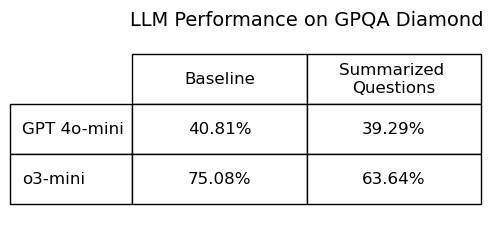

In [623]:
def scores_to_mean(scores):
    mean = np.round(np.mean(scores * 100), 2)
    return f'{mean}%'

data = [
    [
        scores_to_mean(gpt4o_baseline_scores),
        scores_to_mean(gpt4o_summarized_scores),
    ],
    [
        scores_to_mean(o3_baseline_scores),
        scores_to_mean(o3_summarized_scores),
    ]
]

col_labels = ['Baseline', 'Summarized \nQuestions']
row_labels = ['GPT 4o-mini', 'o3-mini']

fig, ax = plt.subplots(figsize=(4.5, 2.5))
ax.axis('off')

table = ax.table(cellText=data, rowLabels=row_labels, colLabels=col_labels,
                 loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 3)

plt.title("LLM Performance on GPQA Diamond", fontsize=14)

plt.show()


In [ ]:
syntactic_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0', '1.0-1.2']
semantic_labels = ['0.80-0.85', '0.85-0.90', '0.90-0.95', '0.95-1.00']         
# note: I removed bins that didn't have a representative number of samples

baseline_acc = semantic_stats['Baseline Accuracy']
summarized_acc = semantic_stats['Summarized Accuracy']

x = np.arange(len(semantic_labels))
bar_width = 0.40 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - bar_width/2, baseline_acc, bar_width, label='Score on Original Qs', color='steelblue')
rects2 = ax.bar(x + bar_width/2, summarized_acc, bar_width, label='Score on Summarized Qs', color='skyblue')

ax.set_ylim(0, 1)
ax.set_xlabel('Semantic Summarization')
ax.set_ylabel('GPQA Score')
ax.set_title('GPT 4o-mini on Summarized GPQA Questions')
ax.set_xticks(x)
ax.set_xticklabels(semantic_labels)
ax.legend()

for i in range(len(semantic_labels)):
    ax.text(x[i], 0.1, f'n={semantic_stats["N"][i]}', ha='center', fontsize=10, color='black', style='italic')

plt.show()